In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
import itertools
from sklearn.model_selection import train_test_split
from scipy.stats import expon, randint, uniform, loguniform
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import precision_recall_curve, average_precision_score
from itertools import cycle
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
data = pd.read_csv("/content/student-mat-ses-grouped.csv")

In [ ]:
def categorize_grade(grade):
    if grade <= 10:
        return 'Fail'  # Low Performance
    else:
        return 'Pass'  # Pass Performance

data['Grade_Category'] = data['G3'].apply(categorize_grade)


In [ ]:
data.head()

In [ ]:
data = data.drop(columns=['G1', 'G2', 'G3'])
grade_category_unique_values = data['Grade_Category'].unique()

data_types = data.dtypes
grade_category_unique_values, data_types

In [ ]:
# encoding cat variables
le = LabelEncoder()

columns_to_encode = data.select_dtypes(include=['object']).columns.drop('Grade_Category')
for column in columns_to_encode:
    data[column] = le.fit_transform(data[column])
data.head()

In [ ]:
# Data preparation for ANOVA
# Convert 'Grade_Category' to a numeric value for ANOVA
data['Grade_Category_Num'] = le.fit_transform(data['Grade_Category'])
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
feature_pairs = itertools.combinations(numeric_columns.drop('Grade_Category_Num'), 2)
anova_results = pd.DataFrame(columns=['Feature_1', 'Feature_2', 'F-Statistic', 'p-Value'])
for pair in feature_pairs:
    formula = f'Grade_Category_Num ~ C({pair[0]}) + C({pair[1]}) + C({pair[0]}):C({pair[1]})'
    model = ols(formula, data).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    interaction_effect = aov_table.loc[f'C({pair[0]}):C({pair[1]})']
    if interaction_effect['PR(>F)'] < 0.05:
        new_row = pd.DataFrame({
            'Feature_1': [pair[0]],
            'Feature_2': [pair[1]],
            'F-Statistic': [interaction_effect['F']],
            'p-Value': [interaction_effect['PR(>F)']]
        })
        anova_results = pd.concat([anova_results, new_row], ignore_index=True)

In [ ]:
# Sort results by F-Statistic
anova_results_sorted = anova_results.sort_values(by='F-Statistic', ascending=False)
anova_results_sorted.head()



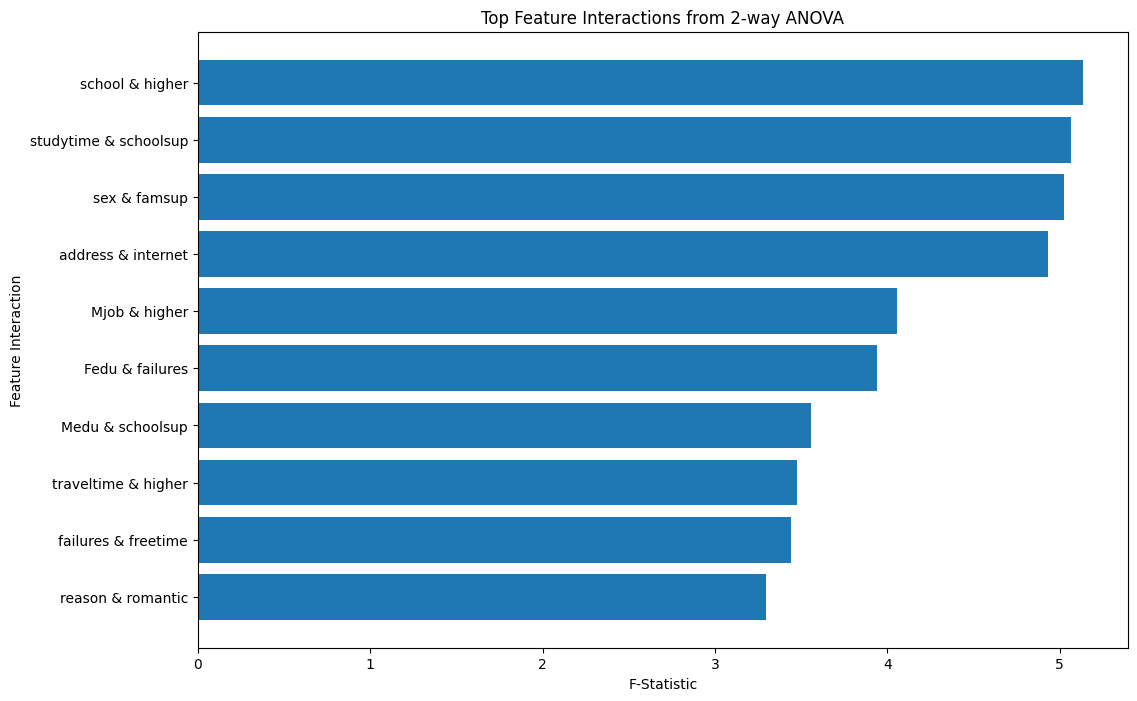

In [ ]:
top_anova_results = anova_results_sorted.head(10).copy()
top_anova_results['Interaction'] = top_anova_results['Feature_1'] + ' & ' + top_anova_results['Feature_2']

# Plotting the F-Statistics for top ANOVA results
plt.figure(figsize=(12, 8))
plt.barh(top_anova_results['Interaction'], top_anova_results['F-Statistic'])
plt.xlabel('F-Statistic')
plt.ylabel('Feature Interaction')
plt.title('Top Feature Interactions from 2-way ANOVA')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Add Anova Features to df
for index, row in top_anova_results.iterrows():
    feature_1 = row['Feature_1']
    feature_2 = row['Feature_2']
    interaction_feature_name = f'{feature_1}_x_{feature_2}'
    data[interaction_feature_name] = data[feature_1] * data[feature_2]
data.head()


In [ ]:
X = data.drop(columns=['Grade_Category', 'Grade_Category_Num'])
y = data['Grade_Category_Num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances and select the top features
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
top_features = feature_importances.nlargest(12, 'Importance')['Feature']
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]


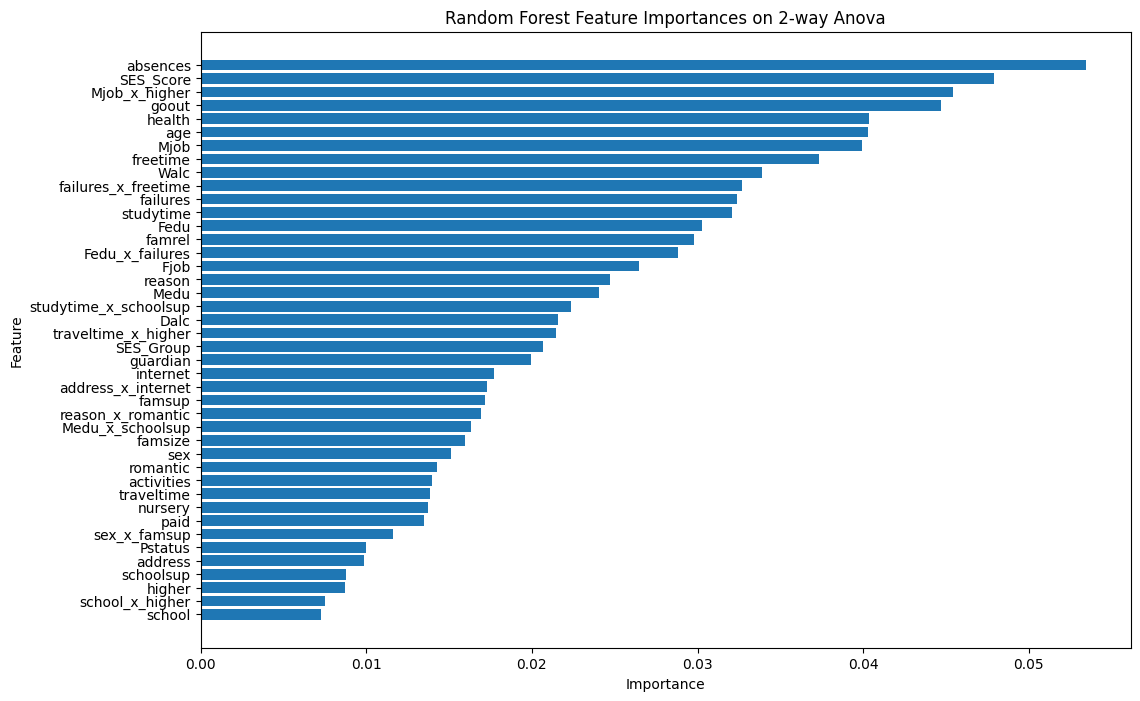

In [ ]:
# Sort the DataFrame and plot by importance
importance_df = feature_importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances on 2-way Anova')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# function to evaluate models
def evaluate_model(model, model_name, X_train, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy}')
    print(f'{model_name} Classification Report:')
    print(classification_report(y_test, y_pred))
    y_pred_prob = model.predict_proba(X_test)
    print(f'{model_name} Prediction Probabilities (First 5 Predictions):')
    print(y_pred_prob[:5])
    print('-' * 50)

In [ ]:
# evaluate Grid and Randomised search
def evaluate_search(search_obj, search_type, X_test, y_test):
    print(f"Best parameters found by {search_type}: ", search_obj.best_params_)
    best_model = search_obj.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of the best model: {accuracy}')
    print(f'Classification Report of the best model ({search_type}):')
    print(classification_report(y_test, y_pred))
    y_pred_prob = best_model.predict_proba(X_test)
    print(f'Prediction Probabilities (First 5 Predictions) of the best model ({search_type}):')
    print(y_pred_prob[:5])
    print('-' * 50)

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_top, y_train)


In [ ]:
evaluate_model(rf_classifier, 'RF', X_train_top, X_test_top, y_test)

RF Accuracy: 0.6708860759493671
RF Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.47      0.58        38
           1       0.64      0.85      0.73        41

    accuracy                           0.67        79
   macro avg       0.69      0.66      0.65        79
weighted avg       0.69      0.67      0.66        79

RF Prediction Probabilities (First 5 Predictions):
[[0.83 0.17]
 [0.85 0.15]
 [0.6  0.4 ]
 [0.52 0.48]
 [0.7  0.3 ]]
--------------------------------------------------


In [ ]:
param_gridRF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_searcRF = GridSearchCV(
    RandomForestClassifier(random_state=42),
                           param_gridRF,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,)

grid_searcRF.fit(X_train_top, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [ ]:
evaluate_search(grid_searcRF, "Gs(RF)", X_test_top, y_test)

Best parameters found by Gs(RF):  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy of the best model: 0.6455696202531646
Classification Report of the best model (Gs(RF)):
              precision    recall  f1-score   support

           0       0.68      0.50      0.58        38
           1       0.63      0.78      0.70        41

    accuracy                           0.65        79
   macro avg       0.65      0.64      0.64        79
weighted avg       0.65      0.65      0.64        79

Prediction Probabilities (First 5 Predictions) of the best model (Gs(RF)):
[[0.81261626 0.18738374]
 [0.82724118 0.17275882]
 [0.54857453 0.45142547]
 [0.45579272 0.54420728]
 [0.83314893 0.16685107]]
--------------------------------------------------


In [ ]:
param_dist = {
    'max_depth': randint(5, 20),
    'min_samples_leaf': randint(1, 10),
    'min_samples_split': randint(2, 20),
    'n_estimators': randint(50, 200)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=200,
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Fit to data
random_search.fit(X_train_top, y_train)

In [ ]:
evaluate_search(random_search, "RS(RF)", X_test_top, y_test)

Best parameters found by RS(RF):  {'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 119}
Accuracy of the best model: 0.6455696202531646
Classification Report of the best model (RS(RF)):
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        38
           1       0.63      0.76      0.69        41

    accuracy                           0.65        79
   macro avg       0.65      0.64      0.64        79
weighted avg       0.65      0.65      0.64        79

Prediction Probabilities (First 5 Predictions) of the best model (RS(RF)):
[[0.79414248 0.20585752]
 [0.83419077 0.16580923]
 [0.57958748 0.42041252]
 [0.50048625 0.49951375]
 [0.7909423  0.2090577 ]]
--------------------------------------------------


In [ ]:

# Best parameters found
best_params = {
    'max_depth': 10,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 300
}

param_grid = {
    'max_depth': [best_params['max_depth'] - 2, best_params['max_depth'], best_params['max_depth'] + 2],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [best_params['min_samples_split'] - 2, best_params['min_samples_split'], best_params['min_samples_split'] + 2],
    'n_estimators': [best_params['n_estimators'] - 100, best_params['n_estimators'], best_params['n_estimators'] + 100]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train_top, y_train)


In [ ]:
evaluate_search(grid_search, "gs(rf)", X_test_top, y_test)

Best parameters found by gs(rf):  {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy of the best model: 0.620253164556962
Classification Report of the best model (gs(rf)):
              precision    recall  f1-score   support

           0       0.65      0.45      0.53        38
           1       0.60      0.78      0.68        41

    accuracy                           0.62        79
   macro avg       0.63      0.61      0.61        79
weighted avg       0.63      0.62      0.61        79

Prediction Probabilities (First 5 Predictions) of the best model (gs(rf)):
[[0.82888889 0.17111111]
 [0.84546882 0.15453118]
 [0.60886298 0.39113702]
 [0.49195486 0.50804514]
 [0.76470437 0.23529563]]
--------------------------------------------------


## LR

In [ ]:
logreg_classifier = LogisticRegression(max_iter=5000)
logreg_classifier.fit(X_train_top, y_train)
evaluate_model(logreg_classifier, "LR", X_train_top, X_test_top, y_test)


LR Accuracy: 0.6075949367088608
LR Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.42      0.51        38
           1       0.59      0.78      0.67        41

    accuracy                           0.61        79
   macro avg       0.62      0.60      0.59        79
weighted avg       0.62      0.61      0.59        79

LR Prediction Probabilities (First 5 Predictions):
[[0.93673196 0.06326804]
 [0.58584588 0.41415412]
 [0.63293903 0.36706097]
 [0.45459989 0.54540011]
 [0.84289156 0.15710844]]
--------------------------------------------------


In [ ]:
logreg_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=5000, random_state=42))
])

param_grid_logreg = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'saga']
}

grid_search_logreg = GridSearchCV(
    logreg_pipeline,
    param_grid=param_grid_logreg,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search_logreg.fit(X_train_top, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('logreg',
                                        LogisticRegression(max_iter=5000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.01, 0.1, 1, 10, 100],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=2)

In [ ]:
evaluate_search(grid_search_logreg, "gs(Lr)", X_test_top, y_test)

Best parameters found by gs(Lr):  {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Accuracy of the best model: 0.6455696202531646
Classification Report of the best model (gs(Lr)):
              precision    recall  f1-score   support

           0       0.69      0.47      0.56        38
           1       0.62      0.80      0.70        41

    accuracy                           0.65        79
   macro avg       0.66      0.64      0.63        79
weighted avg       0.66      0.65      0.63        79

Prediction Probabilities (First 5 Predictions) of the best model (gs(Lr)):
[[0.8527293  0.1472707 ]
 [0.54857531 0.45142469]
 [0.60396928 0.39603072]
 [0.48298371 0.51701629]
 [0.76559992 0.23440008]]
--------------------------------------------------


In [ ]:
param_dist_logreg = {
    'logreg__C': loguniform(1e-4, 1e2),
    'logreg__penalty': ['l2', 'none'],
    'smote__k_neighbors': [1, 2, 3, 4, 5]
}

random_search_logreg = RandomizedSearchCV(
    logreg_pipeline,
    param_distributions=param_dist_logreg,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_logreg.fit(X_train_top, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('smote', SMOTE(random_state=42)),
                                             ('logreg',
                                              LogisticRegression(max_iter=5000,
                                                                 random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'logreg__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b7ab80f5870>,
                                        'logreg__penalty': ['l2', 'none'],
                                        'smote__k_neighbors': [1, 2, 3, 4, 5]},
                   random_state=42, verbose=2)

In [ ]:
evaluate_search(random_search_logreg, "gs(Lr)", X_test_top, y_test)

Best parameters found by gs(Lr):  {'logreg__C': 0.0001899776347411129, 'logreg__penalty': 'l2', 'smote__k_neighbors': 5}
Accuracy of the best model: 0.620253164556962
Classification Report of the best model (gs(Lr)):
              precision    recall  f1-score   support

           0       0.64      0.47      0.55        38
           1       0.61      0.76      0.67        41

    accuracy                           0.62        79
   macro avg       0.63      0.61      0.61        79
weighted avg       0.62      0.62      0.61        79

Prediction Probabilities (First 5 Predictions) of the best model (gs(Lr)):
[[0.52114838 0.47885162]
 [0.50615884 0.49384116]
 [0.50460327 0.49539673]
 [0.4981802  0.5018198 ]
 [0.51598485 0.48401515]]
--------------------------------------------------


##XGB

In [ ]:
strat_k_fold = StratifiedKFold(n_splits=5)

xgb_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb.XGBClassifier(objective='binary:logistic', random_state=42))
])
le = LabelEncoder()
xgb_y = le.fit_transform(y_train)
xgb_yt = le.fit_transform(y_test)

In [ ]:
le = LabelEncoder()
xgb_y = le.fit_transform(y_train)
param_grid_xgb = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 4, 5],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_xgb,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_xgb.fit(X_train_top, xgb_y)

In [ ]:
xgb_yt = le.fit_transform(y_test)
evaluate_search(grid_search_xgb, 'XGB', X_test_top, xgb_yt)

Best parameters found by XGB:  {'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 300, 'xgb__subsample': 0.9}
Accuracy of the best model: 0.620253164556962
Classification Report of the best model (XGB):
              precision    recall  f1-score   support

           0       0.63      0.50      0.56        38
           1       0.61      0.73      0.67        41

    accuracy                           0.62        79
   macro avg       0.62      0.62      0.61        79
weighted avg       0.62      0.62      0.61        79

Prediction Probabilities (First 5 Predictions) of the best model (XGB):
[[0.7961755  0.20382455]
 [0.89033926 0.10966074]
 [0.67898023 0.3210198 ]
 [0.5654657  0.43453428]
 [0.83577657 0.16422346]]
--------------------------------------------------


In [ ]:
param_grid_xgb_new = {
    'xgb__n_estimators': [50, 150, 250],
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'xgb__max_depth': [3, 6, 8],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.5, 0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.2]
}

# Initialize GridSearchCV with the new parameter grid
grid_search_xgb_new = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_xgb_new,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search_xgb_new.fit(X_train_top, xgb_y)


In [ ]:
evaluate_search(grid_search_xgb_new, 'XGB', X_test_top, xgb_yt)

Best parameters found by XGB:  {'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__n_estimators': 50, 'xgb__subsample': 1.0}
Accuracy of the best model: 0.6329113924050633
Classification Report of the best model (XGB):
              precision    recall  f1-score   support

           0       0.64      0.55      0.59        38
           1       0.63      0.71      0.67        41

    accuracy                           0.63        79
   macro avg       0.63      0.63      0.63        79
weighted avg       0.63      0.63      0.63        79

Prediction Probabilities (First 5 Predictions) of the best model (XGB):
[[0.75605285 0.24394716]
 [0.89851487 0.10148516]
 [0.6996763  0.3003237 ]
 [0.63863236 0.36136764]
 [0.9065384  0.0934616 ]]
--------------------------------------------------


## SVM

In [ ]:
svm_classifier = SVC(kernel='linear', random_state=42, probability=True)
svm_classifier.fit(X_train_top, y_train)

In [ ]:
evaluate_model(svm_classifier, "svm", X_train_top, X_test_top, y_test)

svm Accuracy: 0.6582278481012658
svm Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.34      0.49        38
           1       0.61      0.95      0.74        41

    accuracy                           0.66        79
   macro avg       0.74      0.65      0.62        79
weighted avg       0.73      0.66      0.62        79

svm Prediction Probabilities (First 5 Predictions):
[[0.73712596 0.26287404]
 [0.5        0.5       ]
 [0.54832265 0.45167735]
 [0.44335464 0.55664536]
 [0.61406441 0.38593559]]
--------------------------------------------------


In [ ]:
svm_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    #('smote', SMOTE(random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
])

In [ ]:
# Define parameter grid
param_gridsvm = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__degree': [2, 3, 4],
    'svm__gamma': ['scale', 'auto']
}

# Grid search
svm_grid_search = GridSearchCV(svm_pipeline,
                           param_gridsvm,
                           cv=5,
                           scoring='accuracy',
                           verbose=2,
                           n_jobs=-1)

svm_grid_search.fit(X_train_top, y_train)



In [ ]:
evaluate_search(svm_grid_search, 'svm', X_test_top, y_test)

Best parameters found by svm:  {'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Accuracy of the best model: 0.6582278481012658
Classification Report of the best model (svm):
              precision    recall  f1-score   support

           0       0.70      0.50      0.58        38
           1       0.63      0.80      0.71        41

    accuracy                           0.66        79
   macro avg       0.67      0.65      0.65        79
weighted avg       0.67      0.66      0.65        79

Prediction Probabilities (First 5 Predictions) of the best model (svm):
[[0.6075571  0.3924429 ]
 [0.73024135 0.26975865]
 [0.54974871 0.45025129]
 [0.43969324 0.56030676]
 [0.58166849 0.41833151]]
--------------------------------------------------


In [ ]:
param_distributions = {
    'svm__C': uniform(0.1, 10),
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__degree': [2, 3, 4, 5],
    'svm__gamma': ['scale', 'auto']
}
random_searchsvm = RandomizedSearchCV(
    svm_pipeline,
    param_distributions,
    n_iter=100, cv=strat_k_fold,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_searchsvm.fit(X_train_top, y_train)

In [ ]:
evaluate_search(random_searchsvm, 'svm', X_test_top, y_test)

Best parameters found by svm:  {'svm__C': 2.8887135259218186, 'svm__degree': 4, 'svm__gamma': 'auto', 'svm__kernel': 'poly'}
Accuracy of the best model: 0.6075949367088608
Classification Report of the best model (svm):
              precision    recall  f1-score   support

           0       0.68      0.34      0.46        38
           1       0.58      0.85      0.69        41

    accuracy                           0.61        79
   macro avg       0.63      0.60      0.57        79
weighted avg       0.63      0.61      0.58        79

Prediction Probabilities (First 5 Predictions) of the best model (svm):
[[0.69201647 0.30798353]
 [0.53715843 0.46284157]
 [0.42271469 0.57728531]
 [0.42473666 0.57526334]
 [0.70268894 0.29731106]]
--------------------------------------------------


## model stacking

In [ ]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=42))
]

meta_learner = LogisticRegression()

# Stacking ensemble
stacked_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)
stacked_model.fit(X_train_top, xgb_y)

In [ ]:
evaluate_model(stacked_model,"stacked", X_train_top, X_test_top, xgb_yt )

stacked Accuracy: 0.6708860759493671
stacked Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.45      0.57        38
           1       0.63      0.88      0.73        41

    accuracy                           0.67        79
   macro avg       0.70      0.66      0.65        79
weighted avg       0.70      0.67      0.65        79

stacked Prediction Probabilities (First 5 Predictions):
[[0.68062913 0.31937087]
 [0.69249056 0.30750944]
 [0.56043074 0.43956926]
 [0.49813511 0.50186489]
 [0.61766716 0.38233284]]
--------------------------------------------------


In [ ]:
param_grid_stacked = {
    'rf__n_estimators': [100, 200],
    'xgb__n_estimators': [100, 200],
    'final_estimator__C': [0.1, 1, 10]
}

# Grid search
grid_search_stacked = GridSearchCV(
    estimator=stacked_model,
    param_grid=param_grid_stacked,
    cv=5,
    n_jobs=-1,
    verbose=2)
grid_search_stacked.fit(X_train_top, xgb_y)

In [ ]:
evaluate_search(grid_search_stacked, "stacked model",  X_test_top, xgb_yt )

Best parameters found by stacked model:  {'final_estimator__C': 10, 'rf__n_estimators': 200, 'xgb__n_estimators': 200}
Accuracy of the best model: 0.6075949367088608
Classification Report of the best model (stacked model):
              precision    recall  f1-score   support

           0       0.65      0.39      0.49        38
           1       0.59      0.80      0.68        41

    accuracy                           0.61        79
   macro avg       0.62      0.60      0.59        79
weighted avg       0.62      0.61      0.59        79

Prediction Probabilities (First 5 Predictions) of the best model (stacked model):
[[0.71476601 0.28523399]
 [0.77987607 0.22012393]
 [0.52898799 0.47101201]
 [0.50655485 0.49344515]
 [0.67073772 0.32926228]]
--------------------------------------------------


In [ ]:
base_rf = RandomForestClassifier(random_state=42)
ada_boost_rf = AdaBoostClassifier(estimator=base_rf, random_state=42, n_estimators=50)
ada_boost_rf.fit(X_train_top, y_train)

evaluate_model(ada_boost_rf, "ada", X_train_top, X_test_top, y_test)

ada Accuracy: 0.6708860759493671
ada Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.53      0.61        38
           1       0.65      0.80      0.72        41

    accuracy                           0.67        79
   macro avg       0.68      0.67      0.66        79
weighted avg       0.68      0.67      0.66        79

ada Prediction Probabilities (First 5 Predictions):
[[0.85 0.15]
 [0.94 0.06]
 [0.67 0.33]
 [0.51 0.49]
 [0.79 0.21]]
--------------------------------------------------


In [ ]:
ada_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('ada_boost_rf', AdaBoostClassifier(
        estimator=RandomForestClassifier(random_state=42),
        random_state=42))
])

param_dist = {
    'ada_boost_rf__n_estimators': randint(30, 100),
    'ada_boost_rf__learning_rate': [0.01, 0.1, 1]
}

random_searchada = RandomizedSearchCV(
    ada_pipeline,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_searchada.fit(X_train_top, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('smote', SMOTE(random_state=42)),
                                             ('ada_boost_rf',
                                              AdaBoostClassifier(estimator=RandomForestClassifier(random_state=42),
                                                                 random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'ada_boost_rf__learning_rate': [0.01,
                                                                        0.1,
                                                                        1],
                                        'ada_boost_rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe9439bb6d0>},
                   random_state=42, verbose=2)

In [ ]:
evaluate_search(random_searchada, "stacked model",  X_test_top, y_test )

Best parameters found by stacked model:  {'ada_boost_rf__learning_rate': 1, 'ada_boost_rf__n_estimators': 81}
Accuracy of the best model: 0.620253164556962
Classification Report of the best model (stacked model):
              precision    recall  f1-score   support

           0       0.64      0.47      0.55        38
           1       0.61      0.76      0.67        41

    accuracy                           0.62        79
   macro avg       0.63      0.61      0.61        79
weighted avg       0.62      0.62      0.61        79

Prediction Probabilities (First 5 Predictions) of the best model (stacked model):
[[0.78 0.22]
 [0.98 0.02]
 [0.59 0.41]
 [0.67 0.33]
 [0.8  0.2 ]]
--------------------------------------------------


In [ ]:
def get_model_pred(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    return y_test, y_pred, y_pred_prob

In [ ]:
def get_search_pred(search_obj, X_test, y_test):
    best_model = search_obj.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of the best model: {accuracy}')
    print("Classification Report of the best model:", {best_model})
    print(classification_report(y_test, y_pred))
    return y_test, y_pred, y_pred_prob

In [ ]:
# @title Default title text
y_test1, y_pred1, y_pred_prob1 = get_model_pred(ada_boost_rf, X_test_top, y_test)
y_test2, y_pred2, y_pred_prob2 = get_model_pred(rf_classifier, X_test_top, y_test)
y_test_gs1, y_pred_gs1, y_pred_prob_gs1 = get_search_pred(svm_grid_search, X_test_top, y_test)
#y_test_gs2, y_pred_gs2, y_pred_prob_gs2 = get_search_pred(grid_search_logreg, X_test_top, y_test)
y_test_gs3, y_pred_gs3, y_pred_prob_gs3 = get_search_pred(grid_search_xgb_new, X_test_top, xgb_yt)


Accuracy: 0.6708860759493671
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.53      0.61        38
           1       0.65      0.80      0.72        41

    accuracy                           0.67        79
   macro avg       0.68      0.67      0.66        79
weighted avg       0.68      0.67      0.66        79

Accuracy: 0.6708860759493671
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.47      0.58        38
           1       0.64      0.85      0.73        41

    accuracy                           0.67        79
   macro avg       0.69      0.66      0.65        79
weighted avg       0.69      0.67      0.66        79

Accuracy of the best model: 0.6582278481012658
Classification Report of the best model: {Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=1, degree=2, probability=True, random_state=42))])}
              precision  

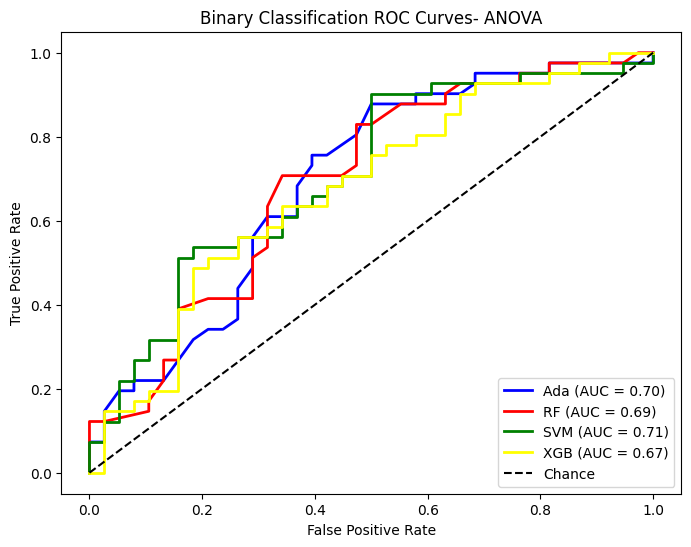

In [ ]:
# Define the plot_binary_roc function
def plot_binary_roc(y_true, y_pred_prob, model_label, color):
    if y_pred_prob.ndim > 1:
        y_pred_prob = y_pred_prob[:, 1]  # Probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_label} (AUC = {roc_auc:.2f})')

color_cycle = cycle(['blue', 'red', 'green', 'yellow'])

plt.figure(figsize=(8, 6))
# Plot ROC curves for each model
plot_binary_roc(y_test, y_pred_prob1, 'Ada', next(color_cycle))
plot_binary_roc(y_test, y_pred_prob2, 'RF', next(color_cycle))
plot_binary_roc(y_test, y_pred_prob_gs1, 'SVM', next(color_cycle))
#plot_binary_roc(y_test, y_pred_prob_gs2, 'LR', next(color_cycle))
plot_binary_roc(y_test, y_pred_prob_gs3, 'XGB', next(color_cycle))

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Classification ROC Curves- ANOVA')
plt.legend(loc="lower right")
plt.show()


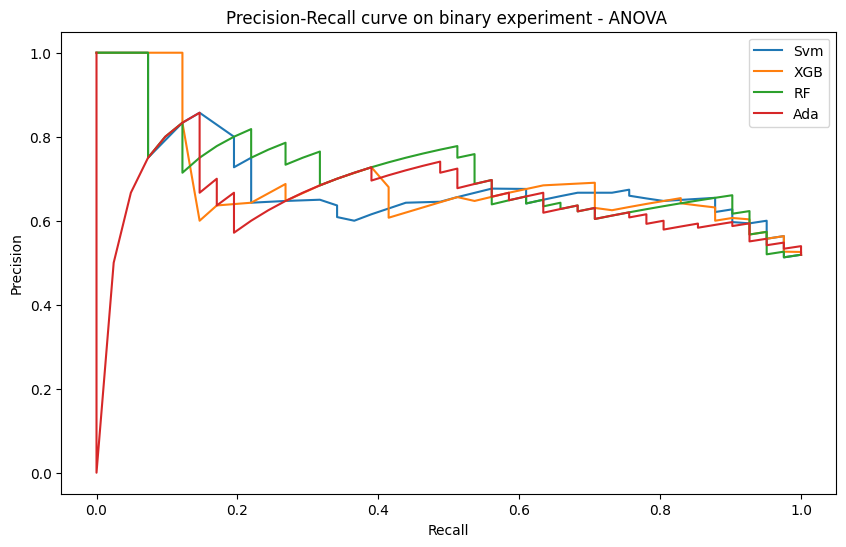

In [ ]:
# Calculate precision and recall for each model
precision_gs2, recall_gs2, _ = precision_recall_curve(y_test1, y_pred_prob1)
precision_gs3, recall_gs3, _ = precision_recall_curve(y_test2, y_pred_prob2)
precision_gs4, recall_gs4, _ = precision_recall_curve(y_test_gs1, y_pred_prob_gs1)
precision_gs5, recall_gs5, _ = precision_recall_curve(y_test_gs3, y_pred_prob_gs3)

# Plotting the precision-recall curves
plt.figure(figsize=(10, 6))
plt.plot(recall_gs2, precision_gs2, label="Svm")
plt.plot(recall_gs3, precision_gs3, label="XGB")
plt.plot(recall_gs4, precision_gs4, label="RF")
plt.plot(recall_gs5, precision_gs5, label="Ada")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve on binary experiment - ANOVA ")
plt.legend()
plt.show()

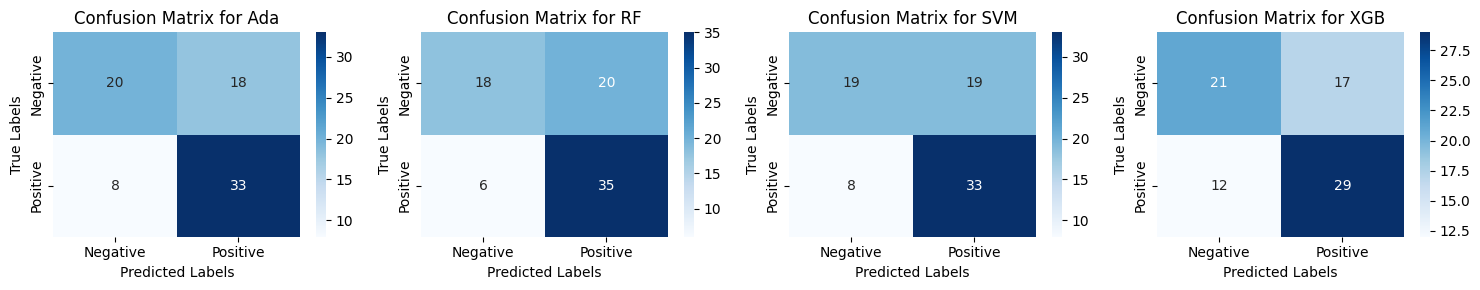

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix for {model_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])

model_predictions = [y_pred1, y_pred2, y_pred_gs1, y_pred_gs3]
model_names = ['Ada', 'RF', 'SVM','XGB']

fig, axes = plt.subplots(nrows=1, ncols=len(model_predictions), figsize=(15, 3))
for ax, y_pred, model_name in zip(axes, model_predictions, model_names):
    plot_confusion_matrix(y_test, y_pred, model_name, ax)

plt.tight_layout()
plt.show()
